In [3]:
import numpy as np
import torch
from torch.utils import data
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib import image
from matplotlib import patches
import zipfile
from pycocotools.coco import COCO
import pandas as pd
import cv2
import random as rn
%matplotlib inline

In [42]:
# Import data frames
train_df = pd.read_pickle('data-2/train_df.pkl')
val_df = pd.read_pickle('data-2/val_df.pkl')

In [43]:
# Takes in a CXHXW image with keypoints and displays it with keypoints
def displayImageWithKeyPoints(img, keypoints, ax=None, show=True):
    img = np.swapaxes(img,0,2)
    img = np.swapaxes(img,0,1)

    #fig = None
    if(ax is None):
        fig, ax = plt.subplots()
    ax.imshow(img)
    w = img.shape[1]
    h = img.shape[0]
    
    # Show kps
    
    for i in range(1, len(keypoints), 2):
        x = keypoints[i-1]
        y = keypoints[i]
        x = (x)*w + w/2
        y = (y)*h + h/2
        if x < 0 or y < 0: continue
        ax.plot(x, y, marker='x', color="red")
    if(show):
        plt.show()

In [44]:
# normalizing transform defined in the DeepPose paper
# y is a 2 vec, b is a 4 vec of bcx, bcy, bw, bh
def N(y, b):
    return [ (y[0]-b[0]) * 1/b[2], (y[1]-b[1]) * 1/b[3]]

def Ninv(y, b):
    return []

In [45]:
# Create datasets for training and validation
class Coco(Dataset):
    def __init__(self, df, source, dimensions, transform=None):
        super().__init__()
        # Dataframe of annotations
        self.df = df
        # Either train or val to indicate set
        self.source = source
        # Square dimensions of image
        self.dimensions = dimensions
        # transform
        self.transform = transform

    def __getitem__(self, index):
        # Get data
        img = image.imread(f'data-2/{self.source}2017/{self.df.iloc[index]["path"]}')
        
        # Apply transforms to image
        if self.transform: img = self.transform(img)
        
        # Return data
        return img, torch.FloatTensor(self.df.iloc[index]["keypoints"])

    def __len__(self):
        return len(self.df)

tensor([[ 0.1094, -0.2866,  0.1406, -0.2988,  0.0469, -0.2988,  0.2031, -0.2988,
          0.0000, -0.3049,  0.2969, -0.2195, -0.1875, -0.2256,  0.4375, -0.2500,
         -0.3906, -0.2988,  0.3281, -0.3659, -0.3438, -0.4024,  0.1562,  0.0488,
         -0.1250,  0.0549,  0.1406,  0.2439, -0.1094,  0.2439,  0.1406,  0.4634,
         -0.0625,  0.4695]])


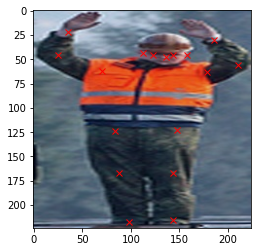

In [49]:
# Data loader
composed_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
train_dataloader = DataLoader(
    dataset=Coco(train_df, 'train', 224, transform=composed_transforms),
    batch_size=1, shuffle=True, num_workers=0
)

# Example from data loader after normalization
img, labels = iter(train_dataloader).next()
print(labels)
a = img[0].numpy()
b = (a - np.min(a))/np.ptp(a)
displayImageWithKeyPoints(b, labels[0])

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("No GPU")

Using the GPU!


In [51]:
# Initialize network
model = models.resnet18(pretrained=True)#models.mobilenet_v2(pretrained=True)

# Freeze params
'''
for param in model.parameters():
    param.requires_grad = False
'''

# Replace FC
#model.classifier = torch.nn.Sequential(
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=False), 
    torch.nn.Linear(512, 4096),
    nn.ReLU(),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(4096, 4096),
    nn.ReLU(),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(4096, 34),
    torch.nn.Sigmoid()
    ) 
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.load_state_dict(torch.load("model.save", map_location=device))

<All keys matched successfully>

Validiation loss was 0.35372409224510193


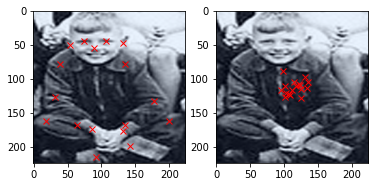

tensor(0.3537, device='cuda:0')

In [53]:
val_dataset = Coco(val_df, 'val', 224, transform=composed_transforms)
batch_size = 32
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')

def check_validation_accuracy(model):
    
    with torch.no_grad():
        loss = 0
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get predictions
            outputs = model(inputs) - 0.5
            loss += criterion(outputs, labels)

        print(f"Validiation loss was {loss}")
    
    # visualize some random gt vs prediction
    idx = rn.randint(0, 150)
    img, labels = val_dataset[idx]
    a = img.numpy()
    b = (a - np.min(a))/np.ptp(a)
    
    img = img.to(device)
    outputs = model(img.unsqueeze(0))
    outputs = outputs.to('cpu') - 0.5

    fig, (ax0, ax1) = plt.subplots(1, 2)
    displayImageWithKeyPoints(b, labels, ax0, False)
    displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)

    return loss 
    

check_validation_accuracy(model)

Training 40 epochs. Dataset is 4037 big. Using batch size 64
64 minibatches are needed per epoch
Minibatch 1/64. Loss 0.07145853340625763
Minibatch 51/64. Loss 0.016718003898859024
Epoch 0/2. Loss 1.393851587548852
Validiation loss was 0.071762315928936


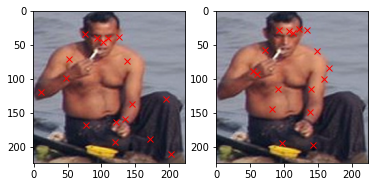

Minibatch 1/64. Loss 0.017009275034070015
Minibatch 51/64. Loss 0.01588936150074005
Epoch 1/2. Loss 0.9850344471633434
Validiation loss was 0.06866790354251862


IndexError: single positional indexer is out-of-bounds

In [55]:
# TRAINING
train_dataset = Coco(train_df, 'train', 224, transform=composed_transforms)
batch_size = 64
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)

# Define loss and optimizer
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

epochs = 40

print(f"Training {epochs} epochs. Dataset is {len(train_dataset)} big. Using batch size {batch_size}")
print(f"{len(train_dataset)//batch_size+1} minibatches are needed per epoch")

train_loss_history = []
val_loss_history = []

# Train for 2 epochs
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs) - 0.5
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 0:
            print(f"Minibatch {i+1}/{len(train_dataset)//batch_size+1}. Loss {loss.item()}")

    # print statistics
    print(f"Epoch {epoch}/2. Loss {running_loss}")
    train_loss_history.append(running_loss)
    val_loss_history.append(check_validation_accuracy(model))

# save model
plt.plot(val_loss_history)
plt.plot(train_loss_history)
torch.save(model.state_dict(), 'model.save')

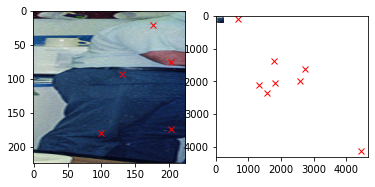

tensor([ -8.1258,  -7.6966,  -1.1502,  -1.2737,   0.3007,  -2.8178,  -6.2262,
          3.0655, -16.6856, -10.0356,  -5.7531,  -1.7282,   4.9751,  -3.9680,
          6.4398,  10.0102,  11.6631,   6.7286,  -2.1547,   2.1698,   7.6152,
          8.6295,  10.9906,   8.3465,   2.5962,  -0.0838,  19.3267,  17.9174,
         -2.2422,  -3.1066,   5.4554,   8.9748,   7.4844,   5.6181],
       grad_fn=<SelectBackward0>)


In [58]:
idx = rn.randint(0, 200)
img, labels = train_dataset[idx]
a = img.numpy()
b = (a - np.min(a))/np.ptp(a)

img = img.to(device)
outputs = model(img.unsqueeze(0))
outputs = outputs.to('cpu')

fig, (ax0, ax1) = plt.subplots(1, 2)
displayImageWithKeyPoints(b, labels, ax0, False)
displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)

print(outputs[0])